# Comparison plot of the various indicators, by response or property type

Here the objective is to see if uncertainty voxets or dissimilarity measures follow similar trends. 

 1. compare Cardinality to Entropy - uncertainty voxets (local measures)
     - for discrete property fieled, we can note a strong correlation
     - for continuous property fields, the standard deviation (instead of cardinality) might be dominated by extreme values in the ensemble, while the continuous entropy will refelect more the variety of patterns.
 2. compare dissimilarity measures (global measures) based on
     - *his*: histogram 
     - *2ps*: two-point statistics (semi-variogram)
     - *mph*: multiple-point histogram
     - *cty*: connectivity
     - *wvt*: wavelet
     - *shd*: topological structural Hamming distance
     - *lsg*: topological Laplacian spectral graph distance
     
For each property field
 - Lithocodes
 - scalar-fields,
 
two figures are generated:

 1. 2D multi-dimensional scaling representation of the global dissimilarity measures
 2. section comparison of local measures of uncertainty (i.e. cardinality and entropy) for each scenario.
 

In [1]:
# import modules
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn import manifold
import pickle

picklefilenamedata = "synthetic-case-data.pickle"
picklefilenamecardinality = "synthetic-case-cardinality.pickle"
picklefilenameentropy = "synthetic-case-entropy.pickle"
picklefilenamehistogram = "synthetic-case-histogram.pickle"
picklefilenamesemivariogram = "synthetic-case-semivariogram.pickle"
picklefilenameconnectivity = "synthetic-case-connectivity.pickle"
picklefilenamemph = "synthetic-case-mph.pickle"
picklefilenamewavelet = "synthetic-case-wavelet.pickle"
picklefilenametopology = "synthetic-case-topology.pickle"

# plotting parameters
slice_ix=0
slice_iy=0
slice_iz=7
aspectratio = 1 # !! in pixels !!
sample_num1 = 0
sample_num2 = 10
myseed=65432

myfs = 24

#%% load computed measures
with open(picklefilenamecardinality, 'rb') as f:
    [crd_lc_100,crd_lc_50A,crd_lc_50B,
     sf_100_crdeq_rng,sf_100_crdeq_std,sf_100_crdeq_rngstd,
     sf_50A_crdeq_rng,sf_50A_crdeq_std,sf_50A_crdeq_rngstd,
     sf_50B_crdeq_rng,sf_50B_crdeq_std,sf_50B_crdeq_rngstd] = pickle.load(f)
with open(picklefilenameentropy, 'rb') as f:
    [ent_lc_100,ent_lc_50A,ent_lc_50B,ent_sf_100,ent_sf_50A,ent_sf_50B] = pickle.load(f)
with open(picklefilenamehistogram, 'rb') as f:
    [dist_hist_lc,dist_hist_sf] = pickle.load(f)
with open(picklefilenamesemivariogram, 'rb') as f:
    [dist_2ps_lc,dist_2ps_sf] = pickle.load(f)
with open(picklefilenameconnectivity, 'rb') as f:
    [dist_cty_lc,dist_cty_sf] = pickle.load(f)
with open(picklefilenamemph, 'rb') as f:
    [dist_mph_lc,dist_mph_sf] = pickle.load(f)
with open(picklefilenamewavelet, 'rb') as f:
    [dist_wvt_lc,dist_wvt_sf] = pickle.load(f)
with open(picklefilenametopology, 'rb') as f:
    [dist_tpl_shd_lc,dist_tpl_shd_sf,dist_tpl_lsgd_lc,dist_tpl_lsgd_sf] = pickle.load(f)


## Define plotting functions

In [2]:

def plot_comparison_dissimilarities(dist_hist,dist_2ps,dist_mph,dist_wvt,dist_cty,dist_tpl_shd,dist_tpl_lsgd,title_spec):
    nsamples = dist_hist.shape[0]
    # SNS plot
    ix=np.tril_indices(nsamples,k=-1)
    df= pd.DataFrame({'his':dist_hist[ix], '2ps':dist_2ps[ix], 'mph':dist_mph[ix], 'cty':dist_cty[ix], 'wvt':dist_wvt[ix],
                      'shd':dist_tpl_shd[ix], 'lsg':dist_tpl_lsgd[ix]})
    sns.set(font_scale=3)
    g = sns.PairGrid(df)
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=3, legend=False)
    plt.show()
    return


def plot_2D_uncertainty_voxets(cardinality,entropy,lgd_card,lgd_ent,title_spec):
    cmin = np.amin(cardinality)
    cmax = np.amax(cardinality)
    emin = np.amin(entropy)
    emax = np.amax(entropy)
    nrm01_card = (cardinality.flatten()-cmin)/(cmax-cmin)
    nrm01_ent = (entropy.flatten()-emin)/(emax-emin)
    fig = plt.figure()
    gs = fig.add_gridspec(1,8)
    ax0 = fig.add_subplot(gs[0, 0:2])
    ax0leg = fig.add_subplot(gs[0, 2])
    ax1 = fig.add_subplot(gs[0, 3:5])
    ax1leg = fig.add_subplot(gs[0, 5])
    ax2 = fig.add_subplot(gs[0, 6:])
    pos0=ax0.imshow(cardinality,cmap='viridis')
    ax0.axis('off'),ax0.set_title(lgd_card),ax0leg.axis('off')
    axins0 = inset_axes(ax0leg,
                       width="10%",  # width = 5% of parent_bbox width
                       height="90%",  # height : 50%
                       loc='center left'
                       )
    fig.colorbar(pos0,cax=axins0,ticks=[]) 
    ax1.imshow(entropy,cmap='viridis')
    ax1.axis('off'),ax1.set_title(lgd_ent),ax1leg.axis('off')
    ax2.scatter(nrm01_card,nrm01_ent,c='blue',marker='+')
    ax2.set_xlabel('norm. cardinality'),ax2.set_ylabel('norm. entropy')
    ax2.set_title(title_spec)
    fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.35, wspace=0.3, hspace=0.5)
    plt.show()
    return

def plot_3D_uncertainty_voxets(cardinality,entropy,lgd_card,lgd_ent,title_spec,slice_ix=0,slice_iy=0,slice_iz=0):
    cmin = np.nanmin(cardinality.flatten())
    cmax = np.nanmax(cardinality.flatten())
    emin = np.nanmin(entropy.flatten())
    emax = np.nanmax(entropy.flatten())
    nrm01_card = (cardinality.flatten()-cmin)/(cmax-cmin)
    nrm01_ent = (entropy.flatten()-emin)/(emax-emin)
    fig = plt.figure()
    gs = fig.add_gridspec(2,12)
    ax00leg = fig.add_subplot(gs[0, 0])
    ax01 = fig.add_subplot(gs[0, 1:3])
    ax02 = fig.add_subplot(gs[0, 3:5])
    ax03 = fig.add_subplot(gs[0, 5:7])
    ax10leg = fig.add_subplot(gs[1, 0])
    ax11 = fig.add_subplot(gs[1, 1:3])
    ax12 = fig.add_subplot(gs[1, 3:5])
    ax13 = fig.add_subplot(gs[1, 5:7])
    ax4 = fig.add_subplot(gs[:, 8:])
    ax01.axis('off'),ax02.axis('off'),ax03.axis('off')
    ax11.axis('off'),ax12.axis('off'),ax13.axis('off')
    ax01.set_title('Map'), ax02.set_title('W (N) E'), ax03.set_title('N (W) S')
    ax11.set_title('Map'), ax12.set_title('W (N) E'), ax13.set_title('N (W) S')
    pos01=ax01.imshow(cardinality[slice_iz,:,:],vmin=cmin,vmax=cmax,cmap='viridis')
    ax02.imshow(cardinality[:,slice_iy,:],vmin=cmin,vmax=cmax,cmap='viridis')
    ax03.imshow(cardinality[:,:,slice_ix],vmin=cmin,vmax=cmax,cmap='viridis')
    ax00leg.axis('off') #,ax00leg.set_title(lgd_card)
    axins00 = inset_axes(ax00leg,
                       width="10%",  # width = 5% of parent_bbox width
                       height="90%",  # height : 50%
                       loc='center left'
                       )
    fig.colorbar(pos01,cax=axins00,label=lgd_card) 
    pos11=ax11.imshow(entropy[slice_iz,:,:],vmin=emin,vmax=emax,cmap='viridis')
    ax12.imshow(entropy[:,slice_iy,:],vmin=emin,vmax=emax,cmap='viridis')
    ax13.imshow(entropy[:,:,slice_ix],vmin=emin,vmax=emax,cmap='viridis')
    ax10leg.axis('off') #,ax10leg.set_title(lgd_ent)
    axins10 = inset_axes(ax10leg,
                       width="10%",  # width = 5% of parent_bbox width
                       height="90%",  # height : 50%
                       loc='center left'
                       )
    fig.colorbar(pos11,cax=axins10,label=lgd_ent) 
    ax4.scatter(nrm01_card,nrm01_ent,c='blue',marker='+')
    ax4.set_xlabel('norm. cardinality'),ax4.set_ylabel('norm. entropy')
    ax4.set_title(title_spec)
    fig.subplots_adjust(left=0.0, bottom=0.0, right=1.15, top=0.55, wspace=0.1, hspace=0.25)
    plt.show()
    return

def plot_uncertainty_voxets(cardinality,entropy,lgd_card,lgd_ent,title_spec,slice_ix=0,slice_iy=0,slice_iz=0):
    dim = len(entropy.shape)
    if dim ==2:
        plot_2D_uncertainty_voxets(cardinality,entropy,lgd_card,lgd_ent,title_spec)
    elif dim==3:
        plot_3D_uncertainty_voxets(cardinality,entropy,lgd_card,lgd_ent,title_spec,slice_ix=slice_ix,slice_iy=slice_iy,slice_iz=slice_iz)
    else:
        print("NA for dimensions>3 or dimensions<2")
    return


# Lithocode plots

04-Mar-2022 (11:27:10) - LITHOCODE DISSIMILARITY COMPARISON START


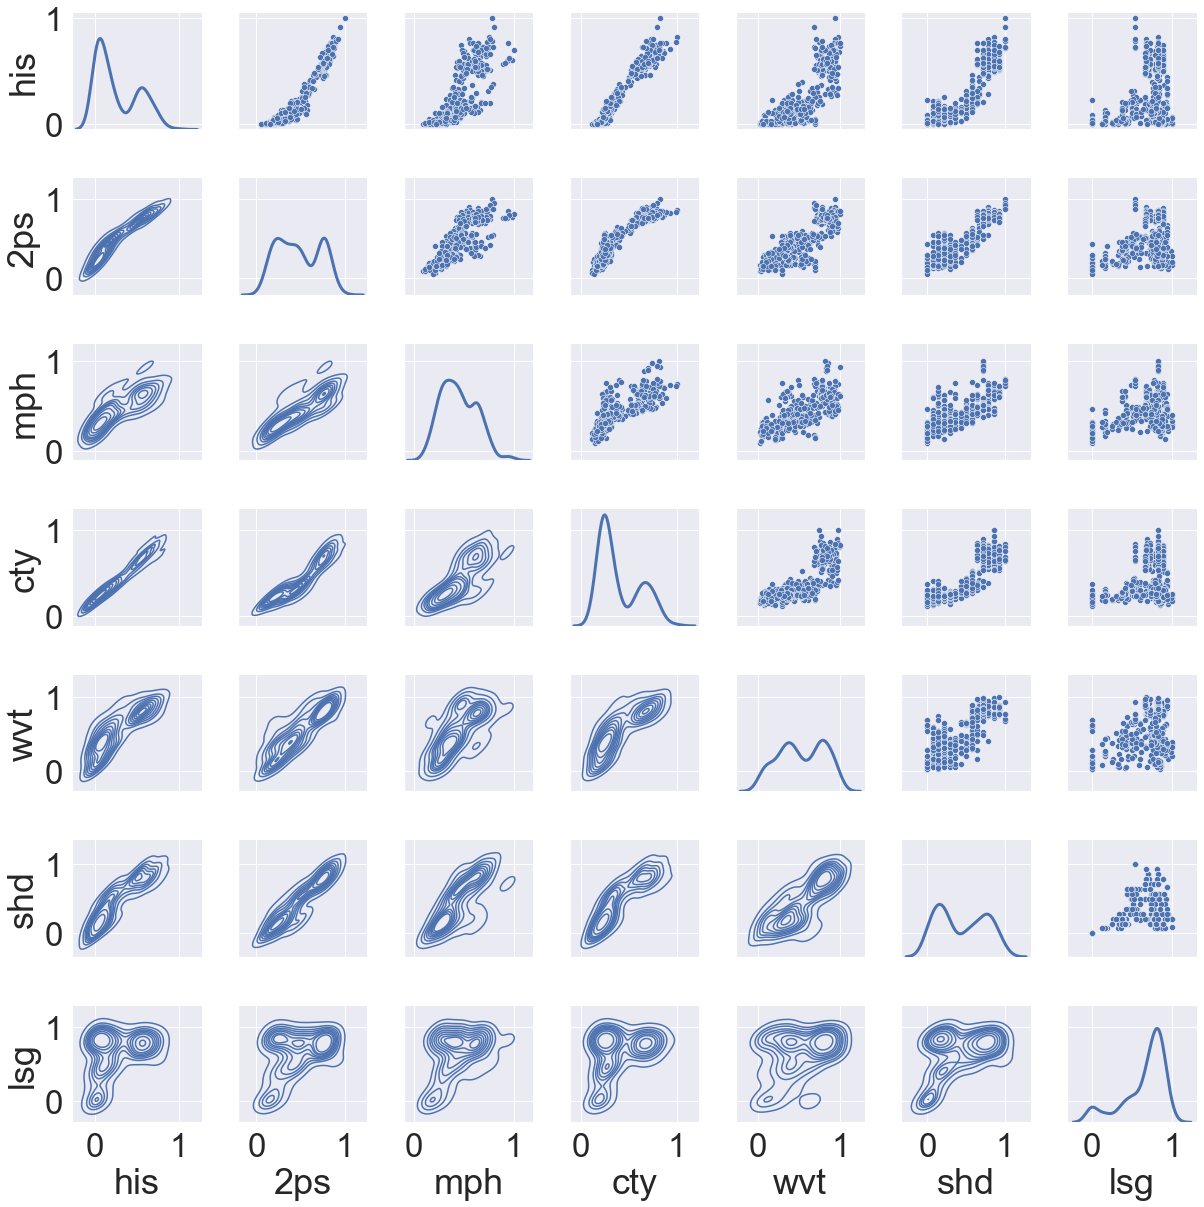

04-Mar-2022 (11:27:26) - LITHOCODE DISSIMILARITY COMPARISON END
04-Mar-2022 (11:27:26) - LITHOCODE UNCERTAINTY VOXETS COMPARISON START


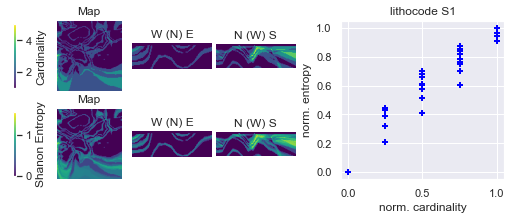

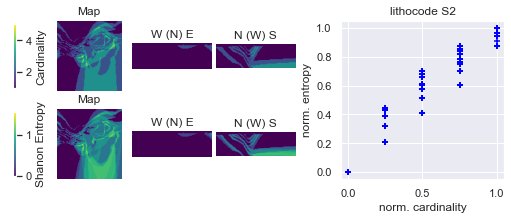

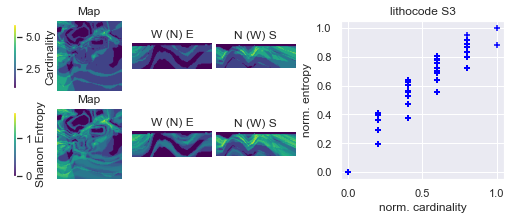

04-Mar-2022 (11:27:30) - LITHOCODE UNCERTAINTY VOXETS COMPARISON END


In [3]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"LITHOCODE DISSIMILARITY COMPARISON START")
# divide by maximum distance for normalization between [0-1]
dist_hist = dist_hist_lc/np.amax(dist_hist_lc)
dist_mph = dist_mph_lc/np.amax(dist_mph_lc)
dist_2ps = dist_2ps_lc/np.amax(dist_2ps_lc)
dist_cty = dist_cty_lc/np.amax(dist_cty_lc)
dist_wvt = dist_wvt_lc/np.amax(dist_wvt_lc)
dist_tpl_shd = dist_tpl_shd_lc/np.amax(dist_tpl_shd_lc)
dist_tpl_lsgd = dist_tpl_lsgd_lc/np.amax(dist_tpl_lsgd_lc)
title_spec = 'lithocode'
plot_comparison_dissimilarities(dist_hist,dist_2ps,dist_mph,dist_cty,dist_wvt,dist_tpl_shd,dist_tpl_lsgd,title_spec)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"LITHOCODE DISSIMILARITY COMPARISON END")

# Cardinality/Entropy comparison 
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"LITHOCODE UNCERTAINTY VOXETS COMPARISON START")
sns.set(font_scale=1)
entropy = ent_lc_100
lgd_ent = 'Shanon Entropy'
cardinality = crd_lc_100
lgd_card = 'Cardinality'
plot_uncertainty_voxets(cardinality,entropy,lgd_card,lgd_ent,title_spec+' S1',slice_ix=slice_ix,slice_iy=slice_iy,slice_iz=slice_iz)

entropy = ent_lc_50A
cardinality = crd_lc_50A
plot_uncertainty_voxets(cardinality,entropy,lgd_card,lgd_ent,title_spec+' S2',slice_ix=slice_ix,slice_iy=slice_iy,slice_iz=slice_iz)

entropy = ent_lc_50B
cardinality = crd_lc_50B
plot_uncertainty_voxets(cardinality,entropy,lgd_card,lgd_ent,title_spec+' S3',slice_ix=slice_ix,slice_iy=slice_iy,slice_iz=slice_iz)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"LITHOCODE UNCERTAINTY VOXETS COMPARISON END")


# Scalar-field plots

04-Mar-2022 (11:27:30) - SCALARFIELD DISSIMILARITY COMPARISON START


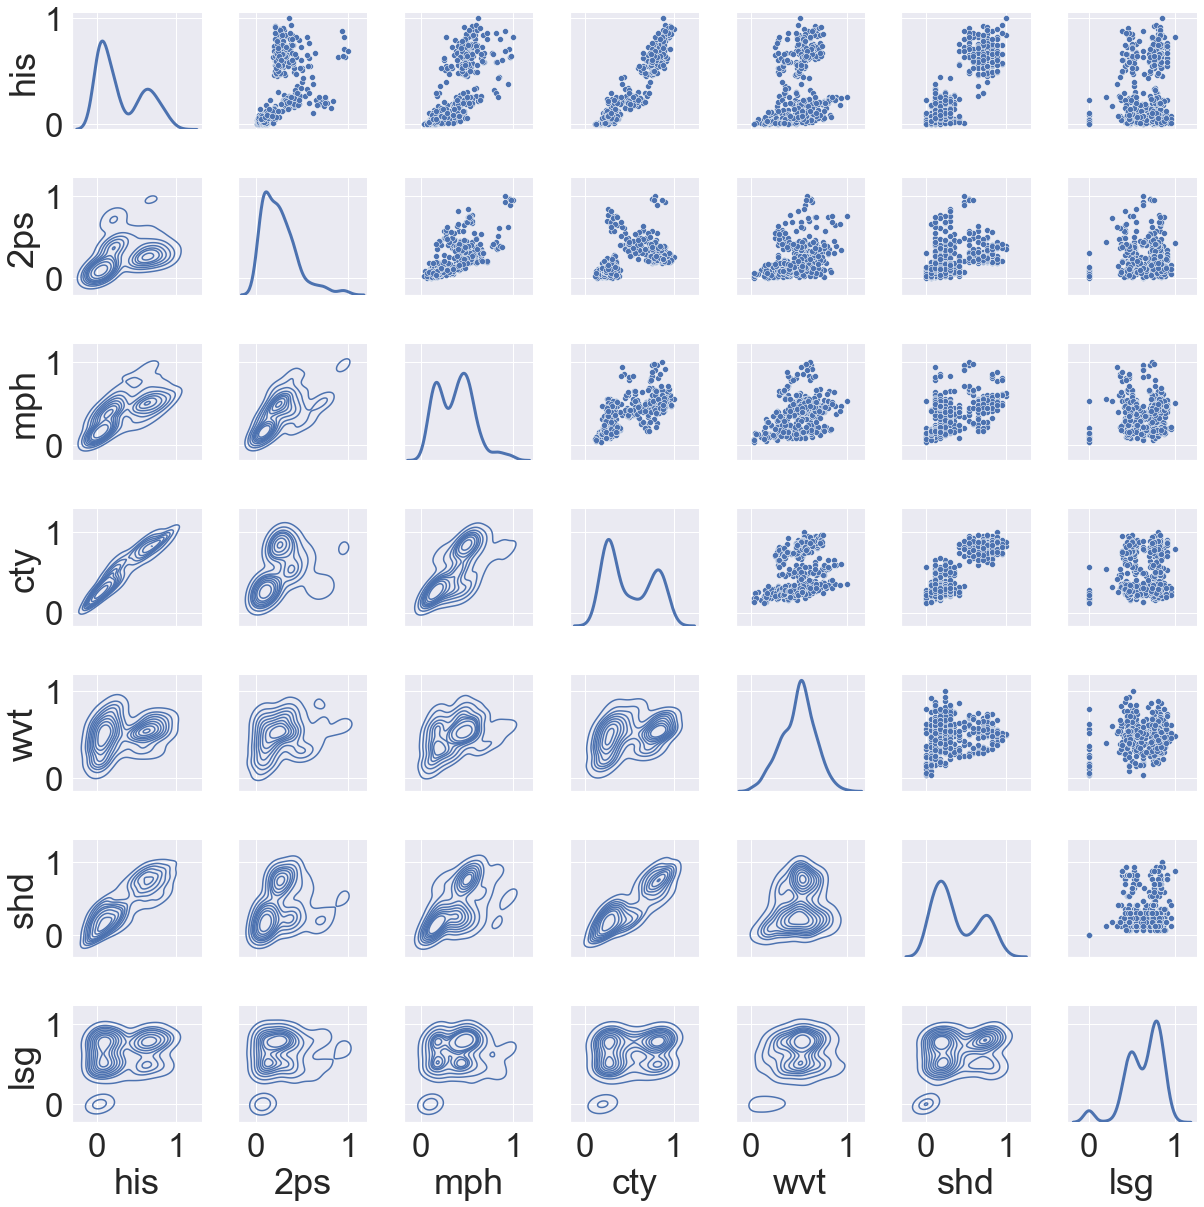

04-Mar-2022 (11:27:46) - SCALARFIELD DISSIMILARITY COMPARISON END
04-Mar-2022 (11:27:46) - SCALARFIELD UNCERTAINTY VOXETS COMPARISON START


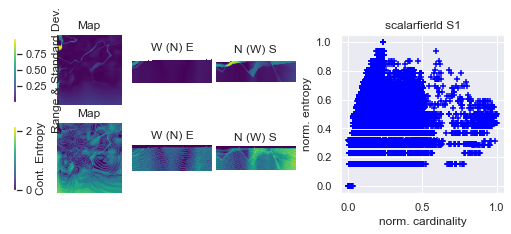

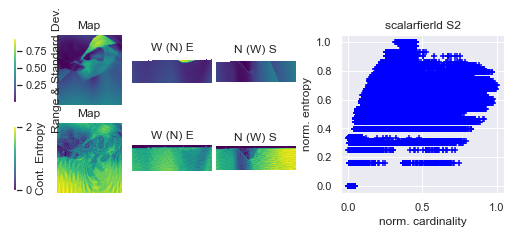

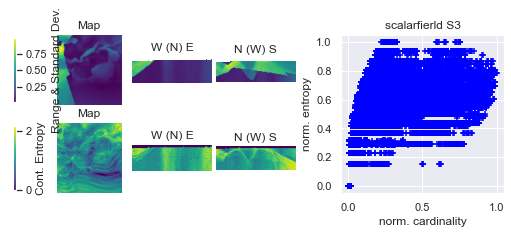

04-Mar-2022 (11:27:49) - SCALARFIELD UNCERTAINTY VOXETS COMPARISON END


In [4]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"SCALARFIELD DISSIMILARITY COMPARISON START")
# divide by maximum distance for normalization between [0-1]
dist_hist = dist_hist_sf/np.amax(dist_hist_sf)
dist_mph = dist_mph_sf/np.amax(dist_mph_sf)
dist_2ps = dist_2ps_sf/np.amax(dist_2ps_sf)
dist_cty = dist_cty_sf/np.amax(dist_cty_sf)
dist_wvt = dist_wvt_sf/np.amax(dist_wvt_sf)
dist_tpl_shd = dist_tpl_shd_sf/np.amax(dist_tpl_shd_sf)
dist_tpl_lsgd = dist_tpl_lsgd_sf/np.amax(dist_tpl_lsgd_sf)
title_spec = 'scalarfierld'
plot_comparison_dissimilarities(dist_hist,dist_2ps,dist_mph,dist_cty,dist_wvt,dist_tpl_shd,dist_tpl_lsgd,title_spec)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"SCALARFIELD DISSIMILARITY COMPARISON END")

# Cardinality/Entropy comparison 
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"SCALARFIELD UNCERTAINTY VOXETS COMPARISON START")
sns.set(font_scale=1)
entropy = ent_sf_100
lgd_ent = 'Cont. Entropy'
cardinality = sf_100_crdeq_rngstd
lgd_card = 'Range & Standard Dev.'
plot_uncertainty_voxets(cardinality,entropy,lgd_card,lgd_ent,title_spec+' S1',slice_ix=slice_ix,slice_iy=slice_iy,slice_iz=slice_iz)

entropy = ent_sf_50A
cardinality = sf_50A_crdeq_rngstd
plot_uncertainty_voxets(cardinality,entropy,lgd_card,lgd_ent,title_spec+' S2',slice_ix=slice_ix,slice_iy=slice_iy,slice_iz=slice_iz)

entropy = ent_sf_50B
cardinality = sf_50B_crdeq_rngstd
plot_uncertainty_voxets(cardinality,entropy,lgd_card,lgd_ent,title_spec+' S3',slice_ix=slice_ix,slice_iy=slice_iy,slice_iz=slice_iz)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"SCALARFIELD UNCERTAINTY VOXETS COMPARISON END")
